<a href="https://colab.research.google.com/github/octaviasst/ECG-ARITMIA-PREDICT-CNN/blob/main/percobaan_aritmia_cnn_bih.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ecgclasifier/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ecgclasifier/mitbih_test.csv',header=None)

In [3]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


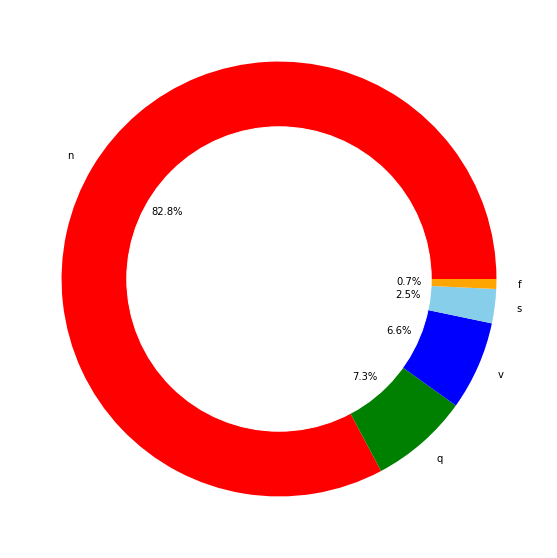

In [4]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [5]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [6]:
equilibre=train_df[187].value_counts()
print(equilibre)

4    20000
3    20000
2    20000
1    20000
0    20000
Name: 187, dtype: int64


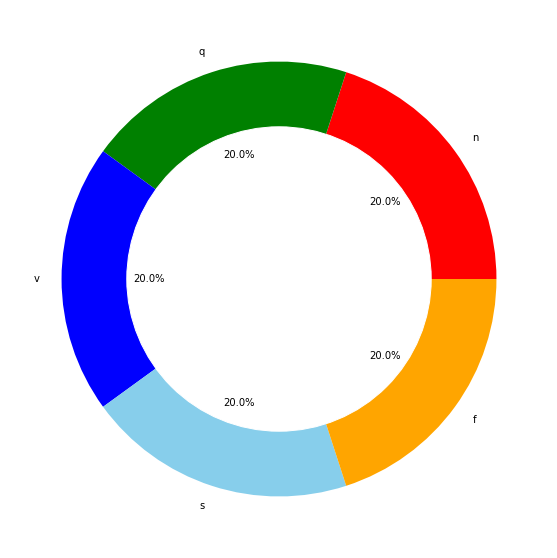

In [7]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

clases

In [8]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [9]:
c

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
27864,1.000000,0.930657,0.591241,0.215328,0.000000,0.087591,0.182482,0.248175,0.288321,0.295620,0.284672,0.273723,0.288321,0.266423,0.277372,0.266423,0.273723,0.266423,0.273723,0.251825,0.273723,0.270073,0.270073,0.259124,0.281022,0.277372,0.288321,0.284672,0.306569,0.310219,0.321168,0.321168,0.346715,0.343066,0.361314,0.361314,0.383212,0.375912,0.394161,0.379562,...,0.291971,0.281022,0.306569,0.29562,0.310219,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72520,0.879661,0.779661,0.493220,0.198305,0.038983,0.003390,0.008475,0.030508,0.027119,0.038983,0.030508,0.000000,0.016949,0.023729,0.020339,0.025424,0.028814,0.015254,0.040678,0.038983,0.023729,0.028814,0.025424,0.027119,0.035593,0.027119,0.025424,0.033898,0.030508,0.033898,0.030508,0.025424,0.038983,0.042373,0.035593,0.074576,0.089831,0.081356,0.100000,0.116949,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
80391,0.959732,0.875839,0.567114,0.347315,0.199664,0.145973,0.115772,0.052013,0.000000,0.008389,0.050336,0.109060,0.204698,0.224832,0.253356,0.248322,0.268456,0.261745,0.266779,0.258389,0.275168,0.268456,0.281879,0.283557,0.298658,0.300336,0.327181,0.328859,0.362416,0.372483,0.412752,0.422819,0.453020,0.471476,0.489933,0.484899,0.486577,0.453020,0.437919,0.402685,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
80971,0.849341,0.945386,1.000000,0.760829,0.395480,0.227872,0.139360,0.124294,0.097928,0.094162,0.071563,0.079096,0.062147,0.067797,0.050847,0.054614,0.045198,0.043315,0.022599,0.028249,0.009416,0.013183,0.003766,0.007533,0.007533,0.026365,0.024482,0.054614,0.069680,0.096045,0.114878,0.148776,0.163842,0.177024,0.163842,0.175141,0.165725,0.169492,0.160075,0.173258,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
86042,0.988930,0.501845,0.523985,0.546125,0.557196,0.549815,0.549815,0.516605,0.420664,0.309963,0.173432,0.084871,0.162362,0.169742,0.114391,0.107011,0.107011,0.099631,0.066421,0.036900,0.047970,0.055351,0.047970,0.066421,0.059041,0.055351,0.047970,0.059041,0.062731,0.073801,0.066421,0.099631,0.084871,0.103321,0.121771,0.151292,0.162362,0.199262,0.214022,0.243542,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


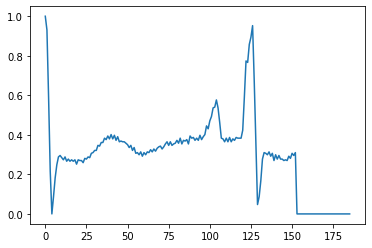

In [10]:
 plt.plot(c.iloc[0,:186])

In [11]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


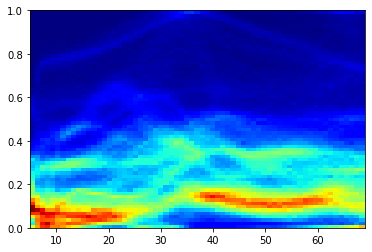

In [12]:
plot_hist(0,70,5,65)

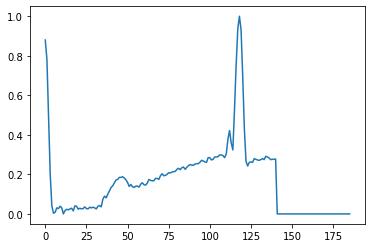

In [13]:
 plt.plot(c.iloc[1,:186])

900000
900000


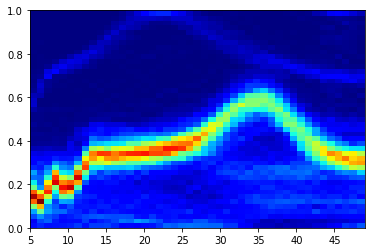

In [14]:
plot_hist(1,50,5,45)

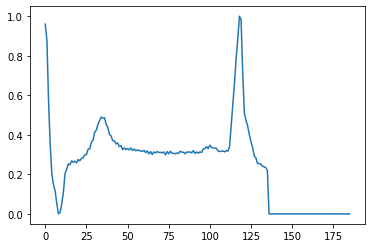

In [15]:
 plt.plot(c.iloc[2,:186])

900000
900000


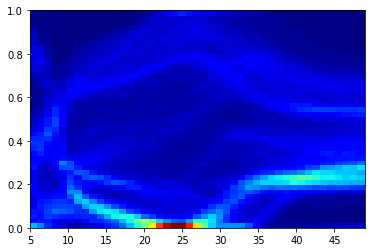

In [16]:
plot_hist(2,50,5,45)

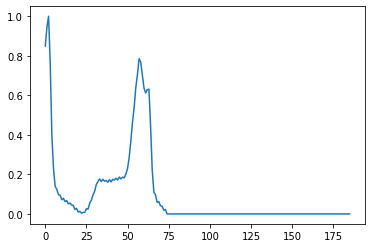

In [17]:
plt.plot(c.iloc[3,:186])

900000
900000


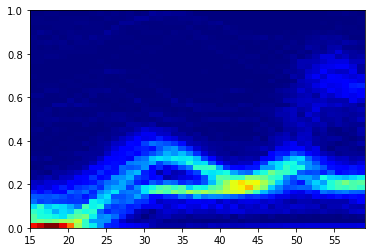

In [18]:
plot_hist(3,60,15,45)

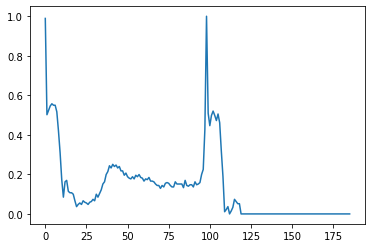

In [19]:
plt.plot(c.iloc[4,:186])

700000
700000


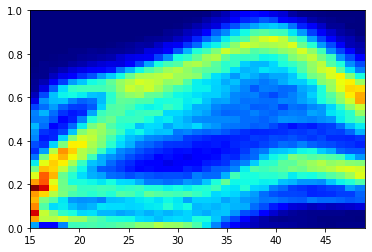

In [20]:
plot_hist(4,50,15,35)

pre-tread

In [21]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

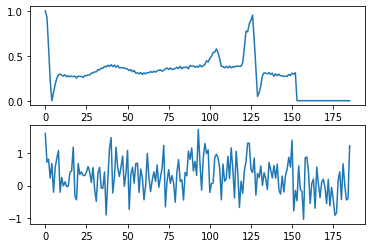

In [22]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [23]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [24]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

network

In [25]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [26]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)
    

In [31]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 105s 33ms/step - loss: 0.8931 - accuracy: 0.6592 - val_loss: 1.1670 - val_accuracy: 0.5166
Epoch 2/40
3125/3125 [==============================] - 103s 33ms/step - loss: 0.7947 - accuracy: 0.6985 - val_loss: 0.9675 - val_accuracy: 0.6176
Epoch 3/40
3125/3125 [==============================] - 101s 32ms/step - loss: 0.7610 - accuracy: 0.7115 - val_loss: 0.8515 - val_accuracy: 0.6891
Epoch 4/40
3125/3125 [==============================] - 102s 33ms/step - loss: 0.7327 - accuracy: 0.7225 - val_loss: 0.8723 - val_accuracy: 0.6601
Epoch 5/40
3125/3125 [==============================] - 102s 33ms/step - loss: 0.7066 - accuracy: 0.7325 - val_loss: 0.7511 - val_accuracy: 0.7225
Epoch 6/40
3125/3125 [==============================] - 104s 33ms/step - loss: 0.6809 - accuracy: 0.7437 - val_loss: 0.8596 - val_accuracy: 0.7087
Epoch 7/40
3125/3125 [==============================] - 106s 34ms/step - loss: 0.6546 - accuracy: 0.7537 - val_loss: 0

Accuracy: 72.25%


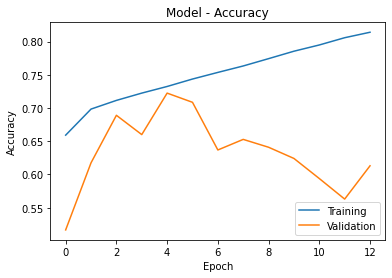

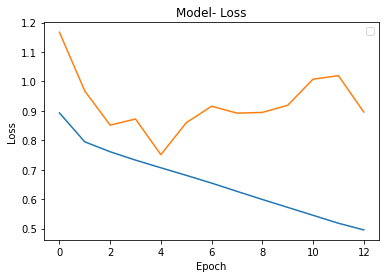

In [32]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


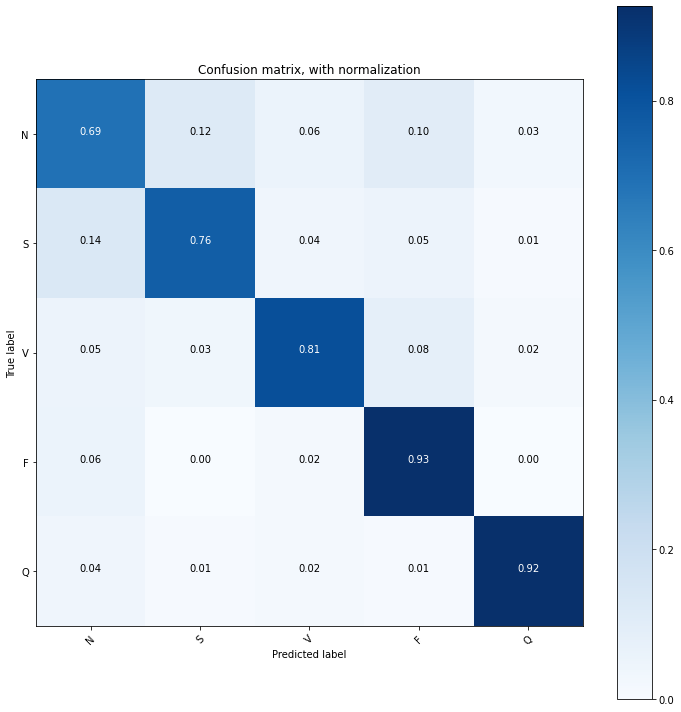

In [33]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()